<html>
<h1><center> Coding Problems </center></h1>
<h2><center> Task 1 </center></h2>
<h3>Problem: Build an autoencoder (with at least 4 encoding layers) for a dataset of 500 grayscale natural images of size 600 × 600. </h3>
<body>
A simple and lightweight (2.46 M parameters and 1.87 GMac computational complexity) convolutional neural network is used to solve the given problem. The network benefits from a convolutional encoder that strides the gray images to latent space using 5 Downsampler Modules. Also, the network uses a convolutional decoder created by 5 Upsampler layers to reconstruct the input.<br>
Finally, the network is trained on 500 samples of a Kaggle dataset <a href="https://www.kaggle.com/datasets/imbikramsaha/bird-groups-classification">Find it here</a>, and the results are elaborated by PSNR and SSIM metrics. The loss function used to train the network is a multi-loss containing MS_SSIM and Total variation losses.<br> The architecture is shown in the following: <br>
<img src="https://raw.githubusercontent.com/sabadijou/images/main/Fig1.jpg?token=GHSAT0AAAAAABK654GHMDUHAM36RR5MG3OKY5A7V5Q" alt="Architecture"></br>
The main points of my solution are listed below:<br>
<ul>
<li>Design a lightweight network inspired by UNet and [1]. It is ten times lighter than the original Unet.</li>
<li> Design UpSampler and DownSampler blocks.</li>
<li> Use Skip Connections to prevent network training from gradient vanishing.</li>
<li> Use Total Variation loss function along with MS_SSIM to increase the quality of outputs and smooth the results.</li>
<li> Measure the network performance using SSIM and PSNR metrics.</li>
</ul>
[1] Mao, X.; Shen, C.; Yang, Y.-B. Image Restoration Using Very Deep Convolutional Encoder-Decoder Networks with Symmetric Skip Connections. In Proceedings of the Advances in Neural Information Processing Systems; Curran Associates, Inc., 2016; Vol. 29.
</body>
</html>

In [2]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import albumentations as A
from tqdm import tqdm 
import torch.nn.functional as F
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from ptflops import get_model_complexity_info
from albumentations.pytorch import ToTensorV2
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from torch.utils.data.sampler import SubsetRandomSampler

The following class loads samples and also applies augmentations and transformers to samples. I used albumentations and torchvision transformer classes to prepare images.

In [3]:
class Folder(torch.utils.data.Dataset):
    def __init__(self, root):
        super(Folder, self).__init__()
        self.root = root
        self.samples_list = os.listdir(self.root)

    def transformer(self, image):
        t1 = A.Compose([A.OneOf([A.Flip(p=0.5), A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5), A.Rotate(limit=180, p=0.5),
                        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
                        A.RandomRain()], p=.8), A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                        ToTensorV2(p=1.0)])
        t2 = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                 transforms.Resize(size=(600, 600))])
        return t2(t1(image=image)['image'])

    def __getitem__(self, idx):
        sample = cv2.imread(os.path.join(self.root, self.samples_list[idx]))
        sample = self.transformer(np.asarray(sample))
        return sample

    def __len__(self):
        return len(self.samples_list)

Here, some samples is shown

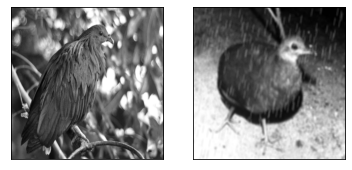

In [4]:
data = Folder(root=r'D:\Datasets\image\birds_kaggle\bird_bern_uni')
number_of_samples = 2
fig, axs = plt.subplots(ncols=number_of_samples, squeeze=False)
for i in range(number_of_samples):
    img = data.__getitem__(i)
    axs[0, i].imshow(np.asarray(img)[0], cmap='gray')
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.show()

<b>set_dataloader</b> splits the dataset into train and test. I used a Pytorch Sampler function called <b>SubsetRandomSampler</b> to implement the function.

In [5]:
def set_dataloader(dataset, train=True):
    validation_split = .2
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    np.random.seed(42)
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    cuda_kwargs = {'pin_memory': True,
                   'shuffle': False}
    if train:
        train_kwargs = {'batch_size': 4,
                        'sampler': train_sampler}
        train_kwargs.update(cuda_kwargs)
        train_loader = torch.utils.data.DataLoader(dataset, **train_kwargs)
        return train_loader
    else:
        test_kwargs = {'batch_size': 4,
                       'sampler': valid_sampler}
        test_kwargs.update(cuda_kwargs)
        test_loader = torch.utils.data.DataLoader(dataset, **test_kwargs)
        return test_loader

Define dataloaders

In [6]:
train_loader = set_dataloader(data, train=True)
test_loader = set_dataloader(data, train=False)

<html>
<body>
Inspired by Unet architecture, <b>DownSampler</b> class using a 2D convolution and a MaxPooling layer to downsample the feature maps. The layers are followed by a BatchNormalization layer and Relu activation function.A <b>DownSampler</b> block is illustrated in the following: <br> 
<center> <img src="https://raw.githubusercontent.com/sabadijou/images/main/Fig2.png" alt="DownSampler Block"> </center>
</body>
</html>

In [7]:
class DownSampler(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2):
        super().__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=(3, 3),
                              stride=1,
                              padding=1,
                              bias=True)

        self.pooling = nn.MaxPool2d(kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.pooling(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

The following class uses DownSampler blocks to create an <b>Encoder</b>. The first layer employs a DownSampler block with four as kernel size, and others use two as the size.

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = DownSampler(1, 16, 4)
        self.conv2 = DownSampler(16, 32)
        self.conv3 = DownSampler(32, 64)
        self.conv4 = DownSampler(64, 128)
        self.conv5 = DownSampler(128, 256)
        self.latent_refine = nn.Conv2d(256, 512, 3, 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.latent_refine(self.conv5(x4))
        return x5, x4, x3, x2

<html>
    <body>
<b>UpSampler block</b> class is shown in the following. This class employs a convolution and a Deconvolution layer to UpSample feature maps. a Batchnormalization, and LeakyRelu follows the layers. The following figure illustrates the block architecture.<br> 
        <center> <img src="https://raw.githubusercontent.com/sabadijou/images/main/Fig3.jpg" alt="DownSampler Block"> </center>
    </body>
 </html>

In [9]:
class UpSampler(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()

        self.conv = nn.Conv2d(in_channels=out_channels,
                              out_channels=out_channels,
                              kernel_size=(3, 3),
                              stride=1,
                              padding=1,
                              bias=True)

        self.up = nn.ConvTranspose2d(in_channels=in_channels,
                                     out_channels=out_channels,
                                     kernel_size=(3, 3),
                                     stride=stride,
                                     padding=0,
                                     bias=True)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

<b>Decoder</b> class uses five UpSampler blocks and an extra deconvolution layer to reconstruct the input. Moreover, the decoder utilizes skip-connection and feature fusion operation to prevent gradient vanishing.<br>

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = UpSampler(512, 128, 2)
        self.deconv2 = UpSampler(128, 64, 2)
        self.deconv3 = UpSampler(64, 32, 2)
        self.deconv4 = UpSampler(32, 16, 2)
        self.deconv5 = UpSampler(16, 8, 4)
        self.out_conv = nn.ConvTranspose2d(8, 1, 5, 1, dilation=2)
    def forward(self, x, x4, x3, x2):
        x = self.deconv1(x)
        x = self.cat_feature_map(x, x4)
        x = self.deconv2(x)
        x = self.cat_feature_map(x, x3)
        x = self.deconv3(x)
        x = self.cat_feature_map(x, x2)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x = self.out_conv(x)
        x = F.interpolate(x, size=(600, 600))
        return x
    # This function crop the encoder feature maps and fuses them to the corresponding decoder feature maps.
    def cat_feature_map(self, x1, x2):
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = x1 + x2
        return x

This class puts all blocks together

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x, x4, x3, x2 = self.encoder(x)
        x = self.decoder(x, x4, x3, x2)
        return x

In [12]:
encoder = Encoder()
decoder = Decoder()
autoencoder = AutoEncoder(encoder, decoder).cuda()

The network elements' complexity and the number of parameters are calculated here.

In [13]:
macs, params = get_model_complexity_info(autoencoder, (1, 600, 600), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

AutoEncoder(
  2.46 M, 100.000% Params, 1.88 GMac, 100.000% MACs, 
  (encoder): Encoder(
    1.57 M, 63.993% Params, 529.78 MMac, 28.159% MACs, 
    (conv1): DownSampler(
      192, 0.008% Params, 64.44 MMac, 3.425% MACs, 
      (conv): Conv2d(160, 0.007% Params, 57.6 MMac, 3.062% MACs, 1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pooling): MaxPool2d(0, 0.000% Params, 5.76 MMac, 0.306% MACs, kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
      (relu): ReLU(0, 0.000% Params, 360.0 KMac, 0.019% MACs, )
      (bn): BatchNorm2d(32, 0.001% Params, 720.0 KMac, 0.038% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): DownSampler(
      4.7 k, 0.191% Params, 105.66 MMac, 5.616% MACs, 
      (conv): Conv2d(4.64 k, 0.189% Params, 104.4 MMac, 5.549% MACs, 16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pooling): MaxPool2d(0, 0.000% Params, 720.0 KMac, 0.038% MACs, kernel_size=2, stride=2, padding=0,

Define Optimizer and learning rate Scheduler.<br>
Note that I considered the weight_decay=5e-4 to prevent overfitting. While weight_decay is not zero, it performs like L2 regularization.

In [43]:
opt = torch.optim.Adadelta(autoencoder.parameters(), weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.01)

The following transformer denormalizes inputs and outputs.

In [44]:
invTrans = transforms.Compose ([transforms.Normalize (mean=[0.],
                                                          std=[1 / 0.5]),
                                    transforms.Normalize (mean=[-0.5],
                                                          std=[1.]),
                                    ])

_ssim function is used to calculate <b>SSIM</b> Metric. This metric calculates Luminance, Contrast, and Structure difference between input and output images. Evaluating these metrics helps us control the quality of the network output's structural features.</br>
The SSIM values ranges between 0 to 1, 1 means perfect match the reconstruct image with original one. Generally SSIM values 0.97, 0.98, 0.99 for good quallty recontruction.
<br>
Note that the following function only supports gray scale input and output (function input size must be (B, 1, H, W)).

In [45]:
# Source: https://github.com/bonlime/pytorch-tools.git
def _ssim(img1, img2):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1 ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2 ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

The following function performs the test phase. The code contains a line function of <b>PSNR</b> used to evaluate the quality of reconstructed images.

In [46]:
img_vis = data.__getitem__(19).unsqueeze(0)
def test():
    loop = tqdm(enumerate(test_loader), total=len(test_loader))
    PSNR = 0
    SSIM = 0
    counter = 0
    for index, test_batch in loop:
        pred = autoencoder(test_batch.float().cuda())
        pred = invTrans(pred) * 255
        target = invTrans(test_batch) * 255
        # calculate PSNR ###
        for i in range(test_batch.shape[0]):
            # PSNR Function
            PSNR = PSNR + (20 * torch.log10(255.0 / torch.sqrt(torch.mean((pred[i] - target.cuda()[i]) ** 2)))).item()
        # calculate SSIM for gray scale images
        for i in range(test_batch.shape[0]):
            SSIM = SSIM + _ssim(pred[i].squeeze(0).detach().cpu().numpy(), target[i].squeeze(0).numpy()).item()
            counter += 1
    fig, axs = plt.subplots(ncols=number_of_samples, squeeze=False)
    pred_vis = autoencoder(img_vis.float().cuda()).detach().cpu()
    axs[0, 0].imshow(np.asarray(pred_vis)[0][0], cmap='gray')
    axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axs[0, 0].set_title('Predicted')
    axs[0, 1].imshow(np.asarray(img_vis)[0][0], cmap='gray')
    axs[0, 1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axs[0, 1].set_title('GT')
    plt.show()
    print('Overall ==>  PSNR: {pnsr}    SSIM: {ssim}'.format(pnsr=PSNR / counter, ssim=SSIM / counter))
    return PSNR / counter, SSIM / counter

In the first experiment, I have trained the network using MSE loss and observed that the outputs were <b>noisy</b> and <b>pixelated</b>. To cover the problem, I employ VT loss because the total variation loss is analogous to regularization loss, and it is introduced to ensure spatial continuity and smoothness in the generated image to avoid noisy and overly pixelated results. <br>
Inspired by [1], I mixed MS_SSIM loss function with VTLoss to increase the quality of results.<br><br>
[1] Zhao, H.; Gallo, O.; Frosio, I.; Kautz, J. Loss Functions for Image Restoration With Neural Networks. IEEE Transactions on Computational Imaging 2017, 3, 47–57.

In [47]:
class TVLoss(nn.Module):
    """Total variation loss (Lp penalty on image gradient magnitude).
    The input must be 4D. If a target (second parameter) is passed in, it is
    ignored.
    ``p=1`` yields the vectorial total variation norm. It is a generalization
    of the originally proposed (isotropic) 2D total variation norm (see
    (see https://en.wikipedia.org/wiki/Total_variation_denoising) for color
    images. On images with a single channel it is equal to the 2D TV norm.
    ``p=2`` yields a variant that is often used for smoothing out noise in
    reconstructions of images from neural network feature maps (see Mahendran
    and Vevaldi, "Understanding Deep Image Representations by Inverting
    Them", https://arxiv.org/abs/1412.0035)
    :attr:`reduction` can be set to ``'mean'``, ``'sum'``, or ``'none'``
    similarly to the loss functions in :mod:`torch.nn`. The default is
    ``'mean'``.
    """

    def __init__(self, p, reduction='mean', eps=1e-8):
        super().__init__()
        if p not in {1, 2}:
            raise ValueError('p must be 1 or 2')
        if reduction not in {'mean', 'sum', 'none'}:
            raise ValueError("reduction must be 'mean', 'sum', or 'none'")
        self.p = p
        self.reduction = reduction
        self.eps = eps

    def forward(self, input, target=None):
        input = F.pad(input, (0, 1, 0, 1), 'replicate')
        x_diff = input[..., :-1, :-1] - input[..., :-1, 1:]
        y_diff = input[..., :-1, :-1] - input[..., 1:, :-1]
        diff = x_diff**2 + y_diff**2
        if self.p == 1:
            diff = (diff + self.eps).mean(dim=1, keepdims=True).sqrt()
        if self.reduction == 'mean':
            return diff.mean()
        if self.reduction == 'sum':
            return diff.sum()
        return diff


<b>Training Loop</b>

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.86it/s]


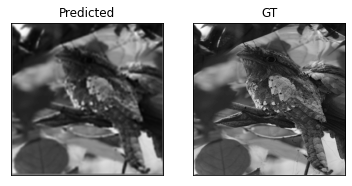

Overall ==>  PSNR: 21.33810891810152    SSIM: 0.6831231215922444


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:12<00:00,  1.96it/s]


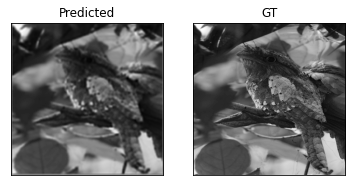

Overall ==>  PSNR: 22.400013461555403    SSIM: 0.69069174104803


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.83it/s]


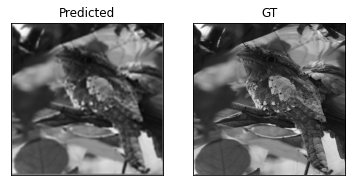

Overall ==>  PSNR: 19.7747871359599    SSIM: 0.6674569402904833


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.83it/s]


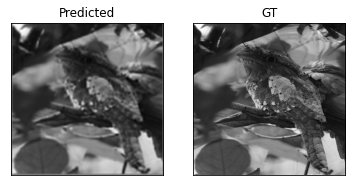

Overall ==>  PSNR: 22.287172396158436    SSIM: 0.696277759562601


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.48it/s]


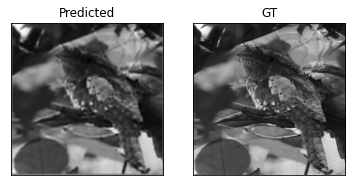

Overall ==>  PSNR: 22.70108791233338    SSIM: 0.692628544261618


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.89it/s]


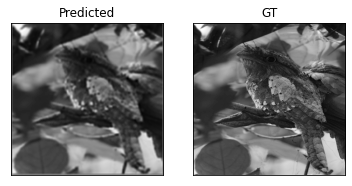

Overall ==>  PSNR: 22.77082632005829    SSIM: 0.6958754445777667


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:12<00:00,  1.94it/s]


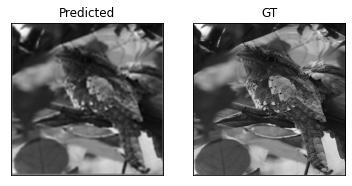

Overall ==>  PSNR: 22.80862973399998    SSIM: 0.6935988593975716


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.89it/s]


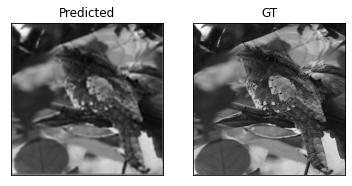

Overall ==>  PSNR: 22.58927545842436    SSIM: 0.6809505381209129


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.92it/s]


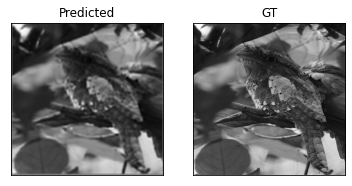

Overall ==>  PSNR: 22.688243413708875    SSIM: 0.6911845193069809


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.88it/s]


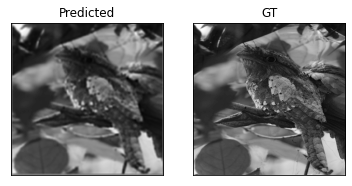

Overall ==>  PSNR: 22.582245010690592    SSIM: 0.6837630416840542


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:12<00:00,  1.94it/s]


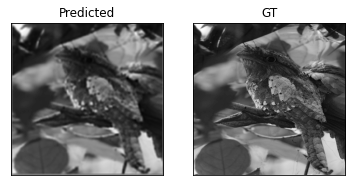

Overall ==>  PSNR: 22.56881090537789    SSIM: 0.6830208846695732


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.90it/s]


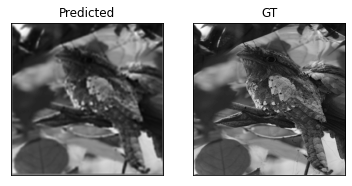

Overall ==>  PSNR: 22.483378813438808    SSIM: 0.6752119883972861


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.90it/s]


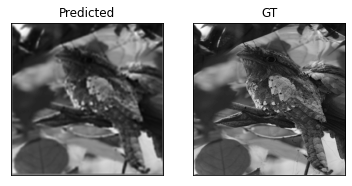

Overall ==>  PSNR: 22.50329515122876    SSIM: 0.6822216324553055


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.89it/s]


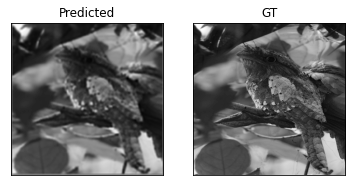

Overall ==>  PSNR: 22.72281400936166    SSIM: 0.6909497064004004


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.89it/s]


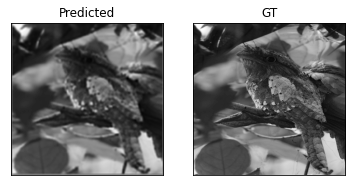

Overall ==>  PSNR: 22.668969616447527    SSIM: 0.6878037219479148


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.89it/s]


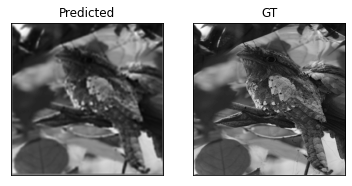

Overall ==>  PSNR: 22.79797257098955    SSIM: 0.6850571522460883


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.92it/s]


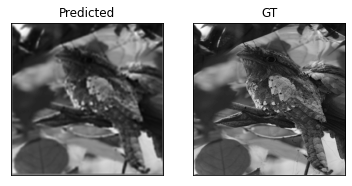

Overall ==>  PSNR: 22.82793959391486    SSIM: 0.6900025480676775


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.87it/s]


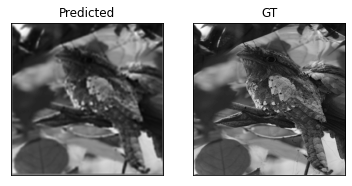

Overall ==>  PSNR: 22.515818723698253    SSIM: 0.6803365735862749


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.91it/s]


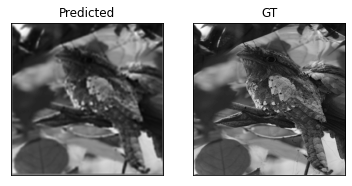

Overall ==>  PSNR: 22.494130989939897    SSIM: 0.6822206647264482


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.90it/s]


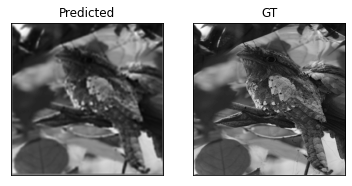

Overall ==>  PSNR: 22.608885676590436    SSIM: 0.6868045490185511


In [48]:
criteria_1 = TVLoss(p=2)
criteria_2 = MS_SSIM(data_range=255, channel=1)
psnr_ep, ssim_ep = [], []
loss_total_avg = []
loss_tv_avg = []
loss_sim_avg = []
numberOf_epoches = 20
for epoch in range(0, numberOf_epoches):
    for param_group in opt.param_groups:
        current_lr = param_group['lr']
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    loss_total = []
    loss_tv = []
    loss_sim = []
    for idx, batch in loop:
        pred = autoencoder(batch.float().cuda())
        loss_1 = criteria_1(pred, batch.cuda())
        loss_2 = criteria_2(invTrans(pred) * 255, invTrans(batch.cuda()) * 255)
        loss = loss_1 - 2 * loss_2
        loss_total.append(loss.item())
        loss_tv.append(loss_1.item())
        loss_sim.append(loss_2.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
        loop.set_postfix({
                          'Epoch': epoch,
                          'Batch_Loss': loss.item(),
                          'current_lr': current_lr
                          })
    loss_total_avg.append(sum(loss_total)/len(loss_total))
    loss_sim_avg.append(sum(loss_sim)/len(loss_sim))
    loss_tv_avg.append(sum(loss_tv)/len(loss_tv))
    scheduler.step()
    metric_1, metric_2 = test()
    psnr_ep.append(metric_1)
    ssim_ep.append(metric_2)

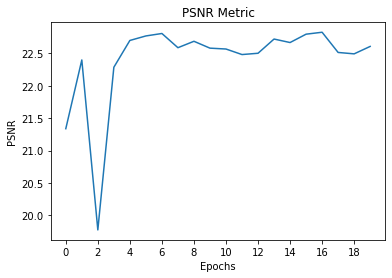

In [57]:
epes = [i for i in range(0, len(psnr_ep))]
plt.plot(epes, psnr_ep)
plt.title('PSNR Metric')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.xticks(np.arange(0, len(epes), 2))
plt.show()

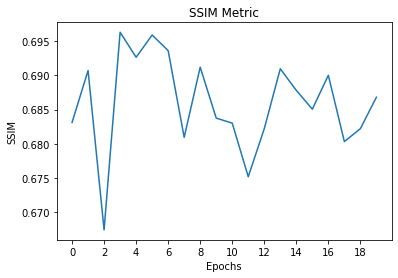

In [58]:
epes = [i for i in range(0, len(psnr_ep))]
plt.plot(epes, ssim_ep)
plt.title('SSIM Metric')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.xticks(np.arange(0, len(epes), 2))
plt.show()

<html>
<h2><center> Task 2 </center></h2>
<h3>Take 1000 images from CIFAR10. Then, given a pair of images from CIFAR10 x1 and x2, build a network that can return both images given their average $\frac{x_{1} + x_{2}}{2}$ as the only input. The design of the architecture and of the input-output mapping is your choice.</h3>
<body>
As shown in the following Figure, I added two extra heads to the pretrained U-Net and then finetuned the whole network. Inspired by [1], the Crossroad L2 Loss function has been employed for training.<br>
 <img src="https://raw.githubusercontent.com/sabadijou/images/main/Fig4.jpg" alt="Architecture"> 
<br>
The solution's main points are listed below:
<ul>
<li> Add two extra heads to U-Net and finetune the network.</li>
<li> Use Crossroad L2 Loss</li>
<li> Measure the network performance using redesigned SSIM and PSNR metrics.</li>
</ul>

[1] Zou, Z.; Lei, S.; Shi, T.; Shi, Z.; Ye, J. Deep Adversarial Decomposition: A Unified Framework for Separating Superimposed Images. In Proceedings of the 2020 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR); June 2020; pp. 12803–12813.
</body>
</html>

In [78]:
import cv2
import torch
import random
import itertools
import numpy as np
import torch.nn as nn
import albumentations as A
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [79]:
image_transformer = A.Compose(
         [A.OneOf([ A.Flip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=180, p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5
            ),
            A.RandomRain()], p=.8),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(p=1.0),
        ])

<b>CifarPair class</b>  returns three images, including: ${x_1}, {x_2}$ and average image (Network input). <br>
<b>get_random_pairs function</b> create random pairs. each pair contains ${x_1}$ and ${x_2}$.This function returns a list of all possible pairs of 1000 Cifar10 samples that can be used to training the network.<br> Obviously, using all pairs can improve the network performance, but I randomly chose 40000 pairs because I couldn't access a GPU for more than 10 hours.

In [80]:
class CifarPair(torch.utils.data.Dataset):
    def __init__(self, transformer):
        super(CifarPair, self).__init__()
        self.cifar = CIFAR10(root='dataset', download=True)
        self.transformer = transformer
        self.pairs = self.get_random_pairs()

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        image_1 = self.transformer(image=np.asarray(self.cifar[pair[0]][0]))['image']
        image_2 = self.transformer(image=np.asarray(self.cifar[pair[1]][0]))['image']
        avg_image = (image_1 + image_2) / 2

        input_dict = {
                        'image_1': image_1.to(torch.float32),
                        'image_2': image_2.to(torch.float32),
                        'avg_image': avg_image.to(torch.float32)
                    }
        return input_dict

    def get_random_pairs(self):
        idx = random.sample(range(len(self.cifar)), 1000)
        pairs = list(itertools.combinations(idx, 2))
        random.shuffle(pairs)
        pairs = random.sample(pairs, k=40000)
        return pairs

    def __len__(self):
        return len(self.pairs)

In [81]:
def set_dataloader(dataset, train=True):
    validation_split = .1
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    np.random.seed(42)
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    cuda_kwargs = {'pin_memory': True,
                   'shuffle': False}
    if train:
        train_kwargs = {'batch_size': 64,
                        'sampler': train_sampler}
        train_kwargs.update(cuda_kwargs)
        train_loader = torch.utils.data.DataLoader(dataset, **train_kwargs)
        return train_loader
    else:
        test_kwargs = {'batch_size': 64,
                       'sampler': valid_sampler}
        test_kwargs.update(cuda_kwargs)
        test_loader = torch.utils.data.DataLoader(dataset, **test_kwargs)
        return test_loader

In [82]:
data_pairs = CifarPair(transformer=image_transformer)
train_dataloader = set_dataloader(dataset=data_pairs, train=True)
test_dataloader = set_dataloader(dataset=data_pairs, train=False)

Files already downloaded and verified


Visualization of some items.

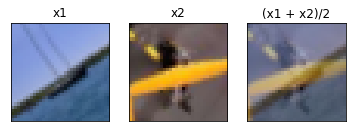

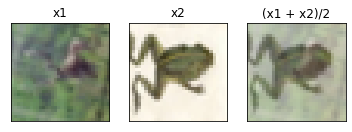

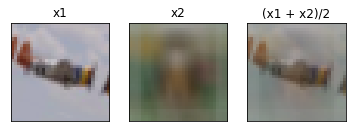

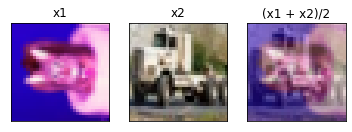

In [83]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
for item in range(0, 4):
    instance = data_pairs.__getitem__(item)
    fig, ax = plt.subplots(nrows=1, ncols=3, squeeze=False)
    ax[0, 0].imshow(invTrans(instance['image_1']).permute(1, 2, 0).cpu().numpy())
    ax[0, 0].set_title('x1')
    ax[0, 1].imshow(invTrans(instance['image_2']).permute(1, 2, 0).cpu().numpy())
    ax[0, 1].set_title('x2')
    ax[0, 2].imshow(invTrans(instance['avg_image']).permute(1, 2, 0).cpu().numpy())
    ax[0, 2].set_title('(x1 + x2)/2')
    for i in range(3):
        ax[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

As mentioned earlier, to solve the problem, I used a U-net model with two extra heads. the heads are utilized to reconstruct ${x_1}$ and ${x_2}$. <b>MainModel class</b> benefits from an instance segmentation toolkit called segmentation_models_pytorch (smp), which is used to implement a shallow U-Net. Two <b>Convolution</b> layers are employed to produce final outputs and the layers perform like a sparator. 

In [100]:
class MainModel(nn.Module):
    def __init__(self):
        super(MainModel, self).__init__()
        self.unet = smp.Unet(encoder_name='resnet34',
                             encoder_weights='imagenet',
                             encoder_depth=3,
                             in_channels=3,
                             classes=32,
                             decoder_channels=[256, 128, 64])
        # self.decoder_1 = nn.ConvTranspose2d(32, 3, 1, 1, padding_mode='zeros')
        # self.decoder_2 = nn.ConvTranspose2d(32, 3, 1, 1, padding_mode='zeros')
        self.decoder_1 = nn.Conv2d(32, 3, 1, 1, padding='same')
        self.decoder_2 = nn.Conv2d(32, 3, 1, 1, padding='same')
        self.bn = nn.BatchNorm2d(3)
    def forward(self, x):
        x = self.unet(x)
        y1 = self.bn(self.decoder_1(x))
        y2 = self.bn(self.decoder_2(x))
        return y1, y2

Note that since we can not specify the order of the two outputs for a typical image decomposition problem (especially when the $\hat{x}_1$ and $\hat{x}_2$ are from the same image domain), the standard pixel-wise L1 or L2 loss functions do not apply to our task. The solution to this problem is to use a loss function that can deal with unordered outputs. The crossroad Loss function (Implemented under the name of MinimumPixelLoss) computes the distance by exchanging the order of the outputs and then takes their minimum value as the final response. <br>
Crossroad L2 loss equation: <br>
<center>
$l_{cross}((x_{1}, x_{2}), (\hat{x_1}, \hat{x_2}))$ = min{$d_{1,1} + d_{2,2}, d_{1,2} + d_{2,1}$} where <br> $d_{i,j} = MSE(x_{i} - \hat{x}_{j}), i,j \in{1, 2}$    
</center>

In [101]:
class MinimumPixelLoss(nn.Module):
    def __init__(self):
        super(MinimumPixelLoss, self).__init__()
        self.criterion = nn.MSELoss(reduce=False)
       
    def forward(self, target_1, target_2, pred1, pred2):

        # compute loss on each img
        loss_1 = torch.mean(self.criterion(pred1, target_1), dim=[1, 2, 3]) \
                 + torch.mean(self.criterion(pred2, target_2), dim=[1, 2, 3])

        # exchange order and compute loss
        loss_2 = torch.mean(self.criterion(pred1, target_2), dim=[1, 2, 3]) \
                 + torch.mean(self.criterion(pred2, target_1), dim=[1, 2, 3])

        loss_min = torch.min(loss_1, loss_2)

        return torch.mean(loss_min)

In [102]:
model = MainModel().cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=100, gamma=0.1)

<b>ssim_rgb</b> function is implemented like _ssim (_ssim described previously), but it supports RGB inputs. I only added a loop to calculate the metric over every channel.

In [103]:
def ssim_rgb(im1, im2):
    ssim_channels = []
    for i in range(3):
        img1 = im1[i]
        img2 = im2[i]
        C1 = (0.01 * 1) ** 2
        C2 = (0.03 * 1) ** 2

        img1 = img1.astype(np.float64)
        img2 = img2.astype(np.float64)
        kernel = cv2.getGaussianKernel(11, 1.5)
        window = np.outer(kernel, kernel.transpose())

        mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
        mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
        mu1_sq = mu1 ** 2
        mu2_sq = mu2 ** 2
        mu1_mu2 = mu1 * mu2
        sigma1_sq = cv2.filter2D(img1 ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
        sigma2_sq = cv2.filter2D(img2 ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
        sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        ssim_channels.append(ssim_map.mean())
    return np.array(ssim_channels).mean()

As stated earlier, this function performs the test phase using two metrics: PSNR and SSIM.
Note that we need to modify the function since we can not specify the order of the two outputs for a typical image decomposition problem. So I redesigned the calculations to measure the final metrics correctly.<br>
<center><font size=4>
$PSNR_{sample}^{final} = max(\frac{PSNR_{sample}(x_{1}, \hat{x}_{1}) + PSNR_{sample}(x_{2}, \hat{x}_{2})}{2}, \frac{PSNR_{batch}(x_{1}, \hat{x}_{2}) + PSNR_{sample}(x_{2}, \hat{x}_{1})}{2})$<br><br>
$SSIM_{sample}^{final} = max(\frac{SSIM_{sample}(x_{1}, \hat{x}_{1}) + SSIM_{sample}(x_{2}, \hat{x}_{2})}{2}, \frac{SSIM_{batch}(x_{1}, \hat{x}_{2}) + SSIM_{sample}(x_{2}, \hat{x}_{1})}{2})$
</center></font>

In [104]:
def test():
    model.eval()
    loop = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
    PSNR11 = 0
    SSIM11 = 0
    PSNR22 = 0
    SSIM22 = 0
    PSNR12 = 0
    SSIM12 = 0
    PSNR21 = 0
    SSIM21 = 0
    counter = 0
    for index, test_pairs in loop:
        pred1, pred2 = model(test_pairs['avg_image'].cuda())
        pred1 = invTrans(pred1)
        pred2 = invTrans(pred2)
        target1 = invTrans(test_pairs['image_1'].cuda()) 
        target2 = invTrans(test_pairs['image_2'].cuda())
        # calculate PSNR
        for i in range(test_pairs['image_1'].shape[0]):
            PSNR11 = PSNR11 + (20 * torch.log10(1.0 / torch.sqrt(torch.mean((pred1[i] - target1.cuda()[i]) ** 2)))).item()
            PSNR22 = PSNR22 + (20 * torch.log10(1.0 / torch.sqrt(torch.mean((pred2[i] - target2.cuda()[i]) ** 2)))).item()
            PSNR12 = PSNR12 + (20 * torch.log10(1.0 / torch.sqrt(torch.mean((pred1[i] - target2.cuda()[i]) ** 2)))).item()
            PSNR21 = PSNR21 + (20 * torch.log10(1.0 / torch.sqrt(torch.mean((pred2[i] - target1.cuda()[i]) ** 2)))).item()
        # calculate SSIM for RGB images
        for i in range(test_pairs['image_1'].shape[0]):
            SSIM11 = SSIM11 + ssim_rgb(pred1[i].detach().cpu().numpy(), target1[i].detach().cpu().numpy()).item()
            SSIM22 = SSIM22 + ssim_rgb(pred2[i].detach().cpu().numpy(), target2[i].detach().cpu().numpy()).item()
            SSIM12 = SSIM11 + ssim_rgb(pred1[i].detach().cpu().numpy(), target2[i].detach().cpu().numpy()).item()
            SSIM21 = SSIM22 + ssim_rgb(pred2[i].detach().cpu().numpy(), target1[i].detach().cpu().numpy()).item()
            counter += 1
    final_PSNR = max((PSNR11 + PSNR22)/2, (PSNR12 + PSNR21)/2) / counter
    final_SSIM = max((SSIM11 + SSIM22)/2, (SSIM12 + SSIM21)/2) / counter
    print('Overall ==>  PSNR {pnsr1}   SSIM {ssim1}'.format(pnsr1=final_PSNR, ssim1=final_SSIM))
    return final_PSNR, final_SSIM

This code block puts everything to gather and train the model.

In [105]:
crossloss = MinimumPixelLoss()
num_epoch = 250
epoch_loss = []
PSNR_metric = []
SSIM_metric = []
for t2epoch in range(num_epoch):
    batch_loss = []
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for idx, pairs in loop:
        out1, out2 = model(pairs['avg_image'].cuda())
        overloss = crossloss(pairs['image_1'].cuda(), pairs['image_2'].cuda(), out1, out2)
        opt.zero_grad()
        overloss.backward()
        opt.step()
        loop.set_postfix({
                          'Epoch': t2epoch,
                          'Batch_Loss': overloss.item(),
                          'Batch_id': idx
                          })
        batch_loss.append(overloss.item())
    epoch_loss.append(np.asarray(batch_loss).mean())
    results = test()
    PSNR_metric.append(results[0])
    SSIM_metric.append(results[1])
    scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.09it/s]


Overall ==>  PSNR 14.702852155819535   SSIM 0.49354180183412544


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.06it/s]


Overall ==>  PSNR 15.168896216213703   SSIM 0.5158387222091285


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.08it/s]


Overall ==>  PSNR 15.014414541453123   SSIM 0.51623314294147


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.07it/s]


Overall ==>  PSNR 15.285765902131796   SSIM 0.5246191837493716


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.03it/s]


Overall ==>  PSNR 15.472802727758884   SSIM 0.5279117288415754


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.405743560433388   SSIM 0.529741966836012


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.03it/s]


Overall ==>  PSNR 15.358944310516119   SSIM 0.5292205539563256


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.476429137021302   SSIM 0.5296273847007495


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.264647823363543   SSIM 0.5130379569851831


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


Overall ==>  PSNR 15.325453064322472   SSIM 0.5295636531334833


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


Overall ==>  PSNR 15.518694369196892   SSIM 0.5315817656938198


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


Overall ==>  PSNR 15.648466106206179   SSIM 0.529723976824301


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


Overall ==>  PSNR 15.5395113671422   SSIM 0.5319183760933349


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.02it/s]


Overall ==>  PSNR 15.561964190483094   SSIM 0.5262731570939633


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


Overall ==>  PSNR 15.567172043144703   SSIM 0.5288519265811197


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.579997720003128   SSIM 0.5247342852839298


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.654164323031903   SSIM 0.5243150733055265


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.03it/s]


Overall ==>  PSNR 15.673841333180667   SSIM 0.5372002819984789


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.81382473129034   SSIM 0.540286063261557


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.02it/s]


Overall ==>  PSNR 15.770205325752496   SSIM 0.5346384538636596


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.854860002964735   SSIM 0.5420530056212576


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.06it/s]


Overall ==>  PSNR 15.704994060993194   SSIM 0.5346801695982966


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


Overall ==>  PSNR 15.629719534546137   SSIM 0.5327018371858485


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


Overall ==>  PSNR 15.73455167979002   SSIM 0.5349907458009929


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.92it/s]


Overall ==>  PSNR 15.622175106436014   SSIM 0.5305723056200022


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:34<00:00,  1.85it/s]


Overall ==>  PSNR 15.358375082343816   SSIM 0.5267897634061997


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.03it/s]


Overall ==>  PSNR 15.60520646673441   SSIM 0.531261331518759


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


Overall ==>  PSNR 15.671734778881072   SSIM 0.5322001934930056


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:34<00:00,  1.85it/s]


Overall ==>  PSNR 15.562483162075281   SSIM 0.5337608854547012


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.5405640642941   SSIM 0.5319208458245657


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.783633172214032   SSIM 0.5390087660498919


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Overall ==>  PSNR 15.681157737761735   SSIM 0.5321789317727234


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.07it/s]


Overall ==>  PSNR 15.601692599475383   SSIM 0.5313296481340415


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.02it/s]


Overall ==>  PSNR 15.678695435643196   SSIM 0.5239020351716087


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.92it/s]


Overall ==>  PSNR 15.707488562762737   SSIM 0.5200535849256925


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.914966716706752   SSIM 0.5406473028171704


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.99it/s]


Overall ==>  PSNR 15.771802351564169   SSIM 0.540906820727191


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Overall ==>  PSNR 15.763346765726805   SSIM 0.5359424356357126


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.03it/s]


Overall ==>  PSNR 15.827676716446877   SSIM 0.5395766140366082


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.688941204845905   SSIM 0.5259005550822187


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.99it/s]


Overall ==>  PSNR 15.581499700784683   SSIM 0.5415935823810726


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


Overall ==>  PSNR 15.868323889493942   SSIM 0.5335891357773636


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:34<00:00,  1.81it/s]


Overall ==>  PSNR 15.841301110059023   SSIM 0.5326352742011083


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:33<00:00,  1.88it/s]


Overall ==>  PSNR 15.864463500142097   SSIM 0.5386020614963093


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Overall ==>  PSNR 15.634483545422555   SSIM 0.5309923591463424


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.97it/s]


Overall ==>  PSNR 15.762016626238823   SSIM 0.5257269841672134


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.804155710428953   SSIM 0.5294004638364977


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.99it/s]


Overall ==>  PSNR 15.784965218544006   SSIM 0.5356633374665776


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.03it/s]


Overall ==>  PSNR 15.656368438184261   SSIM 0.5321118604499586


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.01it/s]


Overall ==>  PSNR 15.494880731374025   SSIM 0.5271882811015092


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.851209219813347   SSIM 0.5316026822660044


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Overall ==>  PSNR 15.668244397759437   SSIM 0.5350200357594254


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 15.903073038339615   SSIM 0.5342311242560471


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.99it/s]


Overall ==>  PSNR 15.829561149388551   SSIM 0.5406186791305251


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.97it/s]


Overall ==>  PSNR 15.75276684859395   SSIM 0.5388239881169642


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.01it/s]


Overall ==>  PSNR 15.868014101147653   SSIM 0.5248624273123742


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.99it/s]


Overall ==>  PSNR 15.635346138060093   SSIM 0.5223599454489037


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Overall ==>  PSNR 15.813987160861492   SSIM 0.5162269649869925


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.01it/s]


Overall ==>  PSNR 15.892195329546928   SSIM 0.5396252894426479


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Overall ==>  PSNR 15.801583214998246   SSIM 0.5308328484448526


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.01it/s]


Overall ==>  PSNR 15.87701581314206   SSIM 0.5356698873337511


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.02it/s]


Overall ==>  PSNR 15.84670857873559   SSIM 0.5390074880888842


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.01it/s]


Overall ==>  PSNR 15.68901636505127   SSIM 0.5288040677249812


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.02it/s]


Overall ==>  PSNR 15.809648680865765   SSIM 0.539104066867674


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.02it/s]


Overall ==>  PSNR 15.656631827861071   SSIM 0.5297420757685259


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Overall ==>  PSNR 15.779150761187077   SSIM 0.5287728782502832


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.02it/s]


Overall ==>  PSNR 15.752771020531654   SSIM 0.5386907710695409


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.99it/s]


Overall ==>  PSNR 15.959900328457355   SSIM 0.5321666997654619


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Overall ==>  PSNR 15.927660851448774   SSIM 0.5335428948807882


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.01it/s]


Overall ==>  PSNR 15.955441071897745   SSIM 0.5384133675252822


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.06it/s]


Overall ==>  PSNR 15.911644220113754   SSIM 0.5341084000356562


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.99it/s]


Overall ==>  PSNR 15.794536372750997   SSIM 0.5323830127145952


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


Overall ==>  PSNR 15.819745928734541   SSIM 0.5246159565297068


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.783053944826126   SSIM 0.5332894042093979


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.979291470587254   SSIM 0.5412039145811636


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.02it/s]


Overall ==>  PSNR 15.828466640651227   SSIM 0.5246329125397231


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.03it/s]


Overall ==>  PSNR 15.800007925480605   SSIM 0.5327833142686564


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.03it/s]


Overall ==>  PSNR 15.889046027094127   SSIM 0.5353822547336555


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Overall ==>  PSNR 15.868683459818364   SSIM 0.5341763883094317


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.02it/s]


Overall ==>  PSNR 15.894537789314985   SSIM 0.5360746897295772


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Overall ==>  PSNR 15.935519069850445   SSIM 0.5344328833388485


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.02it/s]


Overall ==>  PSNR 15.991576030015946   SSIM 0.5437244331368813


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.01it/s]


Overall ==>  PSNR 15.784703843504191   SSIM 0.5352390780247747


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.97it/s]


Overall ==>  PSNR 15.967241976976394   SSIM 0.5360285605952987


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 15.955934062063694   SSIM 0.5210428005410483


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Overall ==>  PSNR 15.882839298516512   SSIM 0.5322163441321258


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Overall ==>  PSNR 15.796138185292483   SSIM 0.5272890016942984


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 15.717420649260282   SSIM 0.5310062800912315


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.01it/s]


Overall ==>  PSNR 15.872188054651023   SSIM 0.5289446495067845


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.92it/s]


Overall ==>  PSNR 15.67242895528674   SSIM 0.5281898889688187


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:29<00:00,  2.16it/s]


Overall ==>  PSNR 15.952233139395714   SSIM 0.5315713554690985


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.97it/s]


Overall ==>  PSNR 16.015001681029798   SSIM 0.5315577015894389


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.02it/s]


Overall ==>  PSNR 15.985789880812169   SSIM 0.5313592805545877


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.99it/s]


Overall ==>  PSNR 15.953238120526075   SSIM 0.5327686057606477


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.97it/s]


Overall ==>  PSNR 15.983993868261576   SSIM 0.5270356065472263


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.03it/s]


Overall ==>  PSNR 16.013346599698068   SSIM 0.5391577393234218


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.03it/s]


Overall ==>  PSNR 15.941493255287408   SSIM 0.5269198187137253


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.03it/s]


Overall ==>  PSNR 16.025039466023443   SSIM 0.5311542276610212


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 16.062310068935155   SSIM 0.5315482977750974


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


Overall ==>  PSNR 15.93721232292056   SSIM 0.5327140978173684


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Overall ==>  PSNR 16.004990703552963   SSIM 0.5293350885568434


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Overall ==>  PSNR 16.0220445522964   SSIM 0.529710304395333


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.01it/s]


Overall ==>  PSNR 16.123968741446735   SSIM 0.5294155100858782


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Overall ==>  PSNR 16.035548511713742   SSIM 0.5304611181213312


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.97it/s]


Overall ==>  PSNR 16.076475188314916   SSIM 0.5336639179417841


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.97it/s]


Overall ==>  PSNR 16.018120718091726   SSIM 0.5291703578642416


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Overall ==>  PSNR 16.10972305738926   SSIM 0.5303277811007606


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.97it/s]


Overall ==>  PSNR 16.125583192646502   SSIM 0.5288648630924186


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.97it/s]


Overall ==>  PSNR 16.056606649011375   SSIM 0.5313078528877265


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.97it/s]


Overall ==>  PSNR 16.044386998593808   SSIM 0.530742005683863


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.99it/s]


Overall ==>  PSNR 16.21448953655362   SSIM 0.5304283294169664


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.01it/s]


Overall ==>  PSNR 16.13146535885334   SSIM 0.5275421131959427


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Overall ==>  PSNR 15.994633487343789   SSIM 0.5288734888018211


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Overall ==>  PSNR 16.141913650810718   SSIM 0.5292934403158562


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Overall ==>  PSNR 16.058599959492682   SSIM 0.5264861396669774


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.100413636088373   SSIM 0.5319587408042655


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Overall ==>  PSNR 16.115028681099414   SSIM 0.5313895912176558


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


Overall ==>  PSNR 16.166960502654312   SSIM 0.5262629004214925


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.04it/s]


Overall ==>  PSNR 16.16280555677414   SSIM 0.5294258095495122


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.03it/s]


Overall ==>  PSNR 16.188797732263804   SSIM 0.529921704328939


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.02it/s]


Overall ==>  PSNR 15.987848809361457   SSIM 0.5303168420939325


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.01it/s]


Overall ==>  PSNR 16.193036243855953   SSIM 0.5285828146749423


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.02it/s]


Overall ==>  PSNR 16.091882256776096   SSIM 0.5334054624949907


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:30<00:00,  2.05it/s]


Overall ==>  PSNR 16.13933671581745   SSIM 0.532134943743847


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.01it/s]


Overall ==>  PSNR 16.068403123259543   SSIM 0.5313198229474628


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Overall ==>  PSNR 16.132543296843767   SSIM 0.5302519418286318


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.91it/s]


Overall ==>  PSNR 16.148614869982005   SSIM 0.5298034322432261


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.072220003902913   SSIM 0.530342126465019


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.030318112939597   SSIM 0.5297694197791163


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Overall ==>  PSNR 16.062061558425427   SSIM 0.5312627544655311


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.92it/s]


Overall ==>  PSNR 16.0623900937438   SSIM 0.5328225260488028


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.072509934604167   SSIM 0.5244946664329319


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.172139873564245   SSIM 0.5282668791736448


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.97it/s]


Overall ==>  PSNR 16.043965914458035   SSIM 0.5328005311600427


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Overall ==>  PSNR 16.056034694492816   SSIM 0.5323677419353819


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.141210057288408   SSIM 0.5274645449844104


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.97it/s]


Overall ==>  PSNR 16.056114038079976   SSIM 0.5238894863569827


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.97it/s]


Overall ==>  PSNR 16.155430929005146   SSIM 0.5362034281718295


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Overall ==>  PSNR 16.056618924915792   SSIM 0.5300315286859661


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.98it/s]


Overall ==>  PSNR 16.170093444556   SSIM 0.5318188223892508


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.08550833106041   SSIM 0.5310733572436284


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.99it/s]


Overall ==>  PSNR 16.122689553380013   SSIM 0.5259684683936768


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:33<00:00,  1.90it/s]


Overall ==>  PSNR 16.08185855937004   SSIM 0.5320889170791591


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.09521226787567   SSIM 0.532956395972837


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:33<00:00,  1.87it/s]


Overall ==>  PSNR 16.17519048368931   SSIM 0.5359720820035636


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.97it/s]


Overall ==>  PSNR 16.069165238440036   SSIM 0.532074720404081


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.09473398721218   SSIM 0.5340908046175907


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:33<00:00,  1.89it/s]


Overall ==>  PSNR 16.111680213570594   SSIM 0.5367290718581589


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.188959768235684   SSIM 0.5276051621188235


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.16911270353198   SSIM 0.5316894697087389


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.126432236760856   SSIM 0.5274193075333427


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.174909290015698   SSIM 0.5323541532942204


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.174634980112316   SSIM 0.5267938537755374


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.97it/s]


Overall ==>  PSNR 16.1197886736691   SSIM 0.5316137668689209


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.05627951553464   SSIM 0.5299033127227226


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.016900597780943   SSIM 0.5303031720828446


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.15047301417589   SSIM 0.5289348410129496


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.159675788223744   SSIM 0.5375868248750941


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.243838857769966   SSIM 0.5290816699652054


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.1876096470654   SSIM 0.5312081439390132


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.183186618566513   SSIM 0.5290233972483366


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.028442175269127   SSIM 0.5303059859767106


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.14739018845558   SSIM 0.5301284793544794


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.21595380192995   SSIM 0.5278044357061679


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.10001356211305   SSIM 0.5318173346593451


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.067268978089093   SSIM 0.5338113146034072


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.12154766330123   SSIM 0.5290133576178082


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.072048825204373   SSIM 0.5266029698341868


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.199912215709688   SSIM 0.5218739227747593


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.085025443196297   SSIM 0.5305856428693545


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.07718087980151   SSIM 0.5302548973274652


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.130843961179256   SSIM 0.5342709073963733


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.198683860301973   SSIM 0.5270848292438015


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.217178359001874   SSIM 0.5246984500246061


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.11235859784484   SSIM 0.5278119722106835


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.97it/s]


Overall ==>  PSNR 16.130249807089566   SSIM 0.5300318228187872


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.22436433964968   SSIM 0.52467974935618


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  1.97it/s]


Overall ==>  PSNR 16.09211899343133   SSIM 0.5287646101368867


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.137766357243063   SSIM 0.5290753299616691


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.129305458277464   SSIM 0.530702418954797


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.09999189940095   SSIM 0.5278115915937655


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.09828246575594   SSIM 0.5281339921526926


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.072038649648427   SSIM 0.5303591386938767


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.91it/s]


Overall ==>  PSNR 16.10185243690014   SSIM 0.5330634686572925


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.113504252403974   SSIM 0.5257408103732936


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:31<00:00,  2.00it/s]


Overall ==>  PSNR 16.13133065006137   SSIM 0.5346214897335196


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.20870683479309   SSIM 0.5269515631570505


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.175393153190612   SSIM 0.5295760470666755


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.115131626546383   SSIM 0.5315251177660283


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.168499359577893   SSIM 0.5267547100533804


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.15105353438854   SSIM 0.5284841197012442


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.12592697831988   SSIM 0.5275063931328708


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.145558242827654   SSIM 0.5288043903181296


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.10771301651001   SSIM 0.5318944770555913


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.1529943125844   SSIM 0.5234719098646594


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.22481489723921   SSIM 0.5323947396660539


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.103216326236726   SSIM 0.5224683202405445


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.19843694359064   SSIM 0.5241366181945757


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.202787677437065   SSIM 0.5238805488788033


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.095437126010655   SSIM 0.5250571082850601


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.119907102555036   SSIM 0.5279359691058075


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.156292448461055   SSIM 0.5344262451896502


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.185042151123284   SSIM 0.5312175248936037


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.079633860856294   SSIM 0.5314668820692561


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.253871761828663   SSIM 0.5249834400970567


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.116952707856893   SSIM 0.533283039682034


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.246302164942026   SSIM 0.5274904973282842


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.204887375235558   SSIM 0.5250576437911122


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.172922037541866   SSIM 0.527576455838774


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.177508533865215   SSIM 0.5282581462514774


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.102110619783403   SSIM 0.5322903088028643


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.92it/s]


Overall ==>  PSNR 16.131153722941875   SSIM 0.5279182288550933


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.093751820266245   SSIM 0.5299632329019484


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.13065703481436   SSIM 0.5278010520629933


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.96it/s]


Overall ==>  PSNR 16.165009199887514   SSIM 0.5313649712934516


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.087724911898373   SSIM 0.5277826716997536


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.95it/s]


Overall ==>  PSNR 16.168577791392803   SSIM 0.5317425662448747


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.129495166242123   SSIM 0.5306357821268334


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.16936123546958   SSIM 0.5354089358243147


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.147944280028344   SSIM 0.5304949493430918


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.216996110081674   SSIM 0.5262990455027926


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.093862684488297   SSIM 0.5302164229921276


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.19971427154541   SSIM 0.5285639337723803


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.126292182177306   SSIM 0.5291896554139196


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.157815490454436   SSIM 0.5317044245589273


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.169024429261686   SSIM 0.5277910284035119


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.92it/s]


Overall ==>  PSNR 16.178352354347705   SSIM 0.5281628423522428


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.92it/s]


Overall ==>  PSNR 16.186452261269093   SSIM 0.5275236473015806


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.200643014758825   SSIM 0.5260615612714026


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.19371920645237   SSIM 0.5272882770213976


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.175663592725993   SSIM 0.5328008494937986


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.300834759145975   SSIM 0.523716253472675


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.223198191642762   SSIM 0.53169115723044


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.143235628843307   SSIM 0.5311745747685149


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.237173995494842   SSIM 0.5271001911660614


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.94it/s]


Overall ==>  PSNR 16.17490474459529   SSIM 0.5276485031090374


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.247902644515037   SSIM 0.526877631337202


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.191122271955013   SSIM 0.5281080860685082


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.238605398118494   SSIM 0.5274821540195644


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.136213483691215   SSIM 0.5284291569192953


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.09419221186638   SSIM 0.5299395666138187


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.91it/s]


Overall ==>  PSNR 16.15750505286455   SSIM 0.5345634054053879


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.91it/s]


Overall ==>  PSNR 16.10108769914508   SSIM 0.5307668933975128


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:33<00:00,  1.89it/s]


Overall ==>  PSNR 16.186938510686158   SSIM 0.5256568025764777


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:33<00:00,  1.88it/s]


Overall ==>  PSNR 16.189682015508414   SSIM 0.5317994022926534


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.162853460609913   SSIM 0.5263162685174327


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.234640148550273   SSIM 0.5281569399547822


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.91it/s]


Overall ==>  PSNR 16.294311474710703   SSIM 0.524402518463848


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.93it/s]


Overall ==>  PSNR 16.180496141910552   SSIM 0.5284401511590052


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:32<00:00,  1.92it/s]

Overall ==>  PSNR 16.211225720912218   SSIM 0.5312521680222677


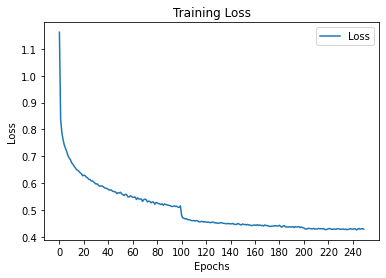

In [106]:
import matplotlib.pyplot as plt
Epochs_t2 = [i for i in range(0, len(epoch_loss))]
plt.plot(Epochs_t2, epoch_loss, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0, len(Epochs_t2), 20))
plt.legend(loc='best')
plt.show()

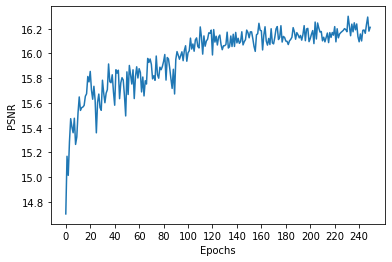

In [108]:
Epochs_ = [i for i in range(0, 250)]
plt.plot(Epochs_, PSNR_metric)
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.xticks(np.arange(0, len(Epochs_), 20))
plt.show()

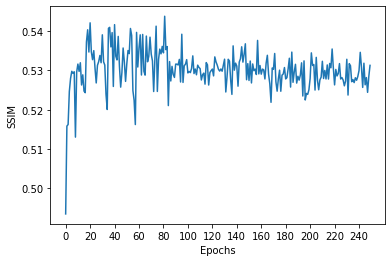

In [109]:
Epochs_ = [i for i in range(0, len(SSIM_metric))]
plt.plot(Epochs_, SSIM_metric)
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.xticks(np.arange(0, len(Epochs_), 20))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


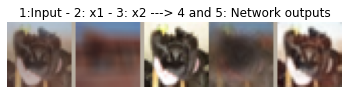

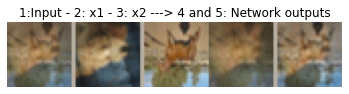

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


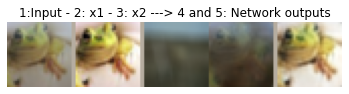

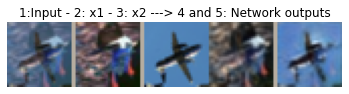

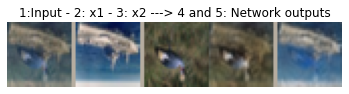

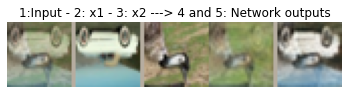

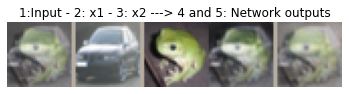

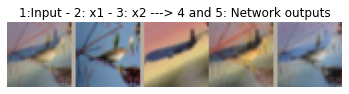

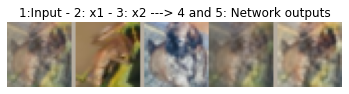

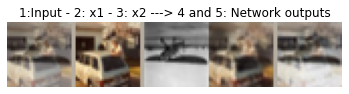

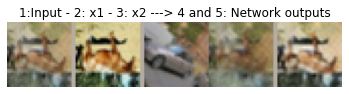

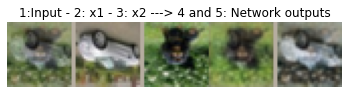

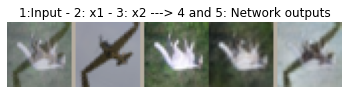

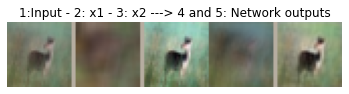

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


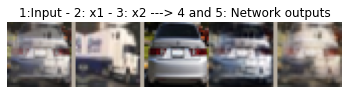

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


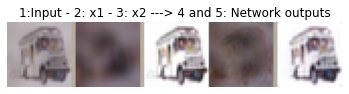

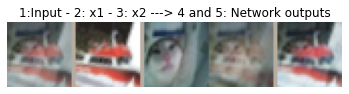

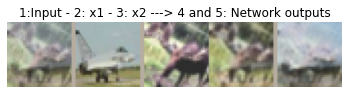

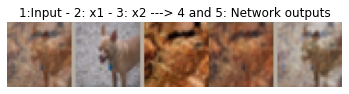

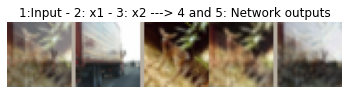

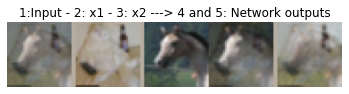

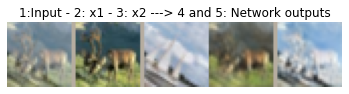

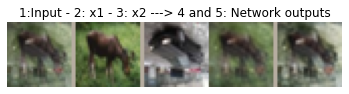

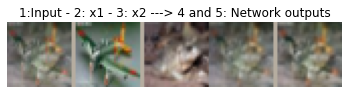

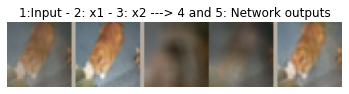

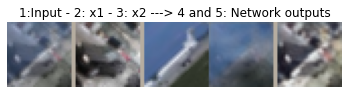

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


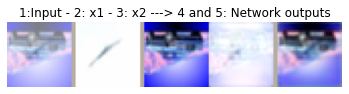

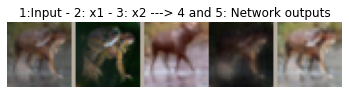

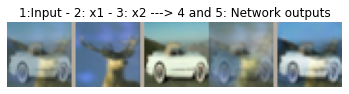

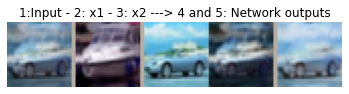

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


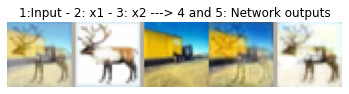

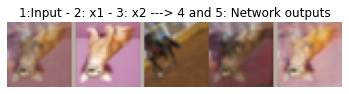

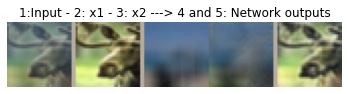

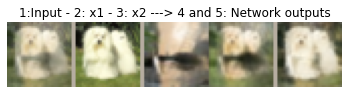

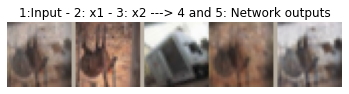

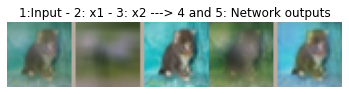

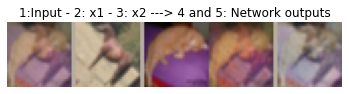

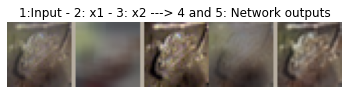

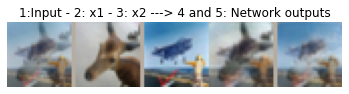

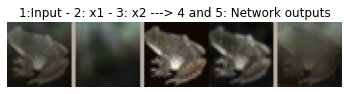

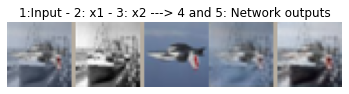

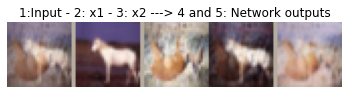

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


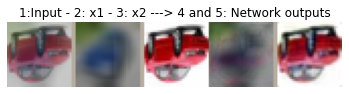

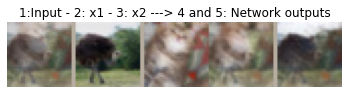

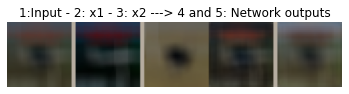

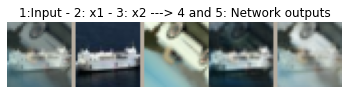

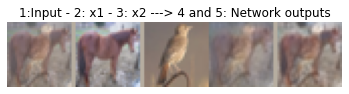

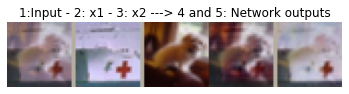

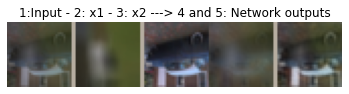

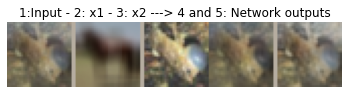

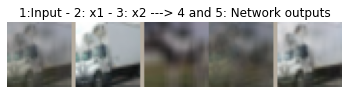

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


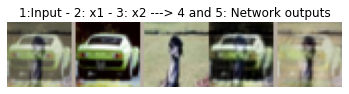

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


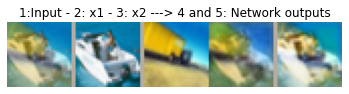

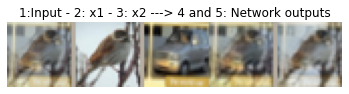

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


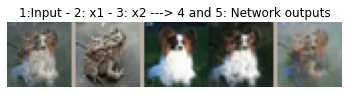

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


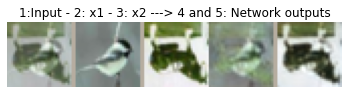

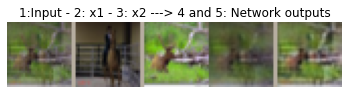

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


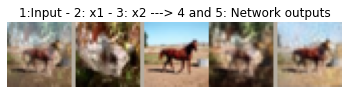

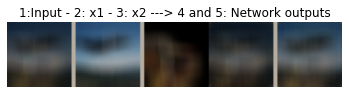

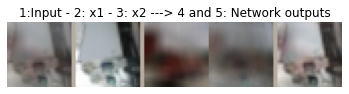

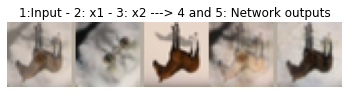

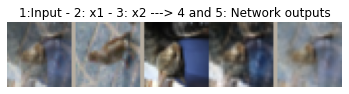

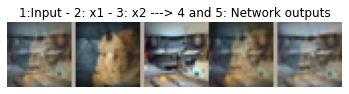

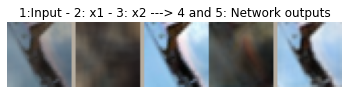

In [111]:
# model.load_state_dict(torch.load(r'C:\Users\asus\Desktop\model.pth'))
torch.save(model.state_dict(), 'mm.pth')
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
for idx, pairs in enumerate(train_dataloader):
    out1, out2 = model(pairs['avg_image'].cuda())
    space = torch.ones(3, 32, 2).cuda()
    final_res = torch.ones(3, 2, 166).cuda()
    space_2 = torch.ones (3, 2, 166).cuda()
    for i in range(out2.shape[0]):
        result = torch.cat([pairs['avg_image'][i].cuda(), space,
                            pairs['image_1'][i].cuda(), space, pairs['image_2'][i].cuda(),
                            out1[i].cuda(), space, out2[i].cuda()], dim=2)
        plt.imshow(invTrans(result).permute(1, 2, 0).detach().cpu().numpy())
        plt.axis('off')
        plt.title('1:Input - 2: x1 - 3: x2 ---> 4 and 5: Network outputs')
        plt.show()
    break